<img src="https://www.epfl.ch/about/overview/wp-content/uploads/2020/07/logo-epfl-1024x576.png" 
     style="padding-right:10px;width:140px;float:left">
<h2 style="white-space: nowrap">Neural Signal and Signal Processing (NX-421)</h2>
<hr style="clear:both">
<h1 style="color:black">SOLUTION : Exercise 10 - EMG data preprocessing</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
import pandas as pd

This exercise is about learning **EMG signal preprocessing techniques** and **analyzing EMG** data. There are two parts in this exercise:

**Part a:** Focuses on basic filtering techniques.  
**Part b:** Builds upon Part a and additionally introduces data inspection, which is critically important in real applications.

--------------------------------------------------------------------------------------------------------------------------------------------
## Part a 

In the first part, we will work on the preprocessing of an EMG dataset acquired on the forearm of a subject while performing grasping. 

First, let's load the recording. Before thinking of any data processing techniques, we should know the data structure/shape and understand its meaning.

In this case, the rows (0th dimension) represents the number of data points in time. The columns (or 1st dimension) represents the number of channels in each data point.

<div style="background-color:#ffdddd; padding:10px; border-left:5px solid #ff0000; border-radius:5px; margin:5px 0;">
<strong>TODO:</strong> Load the data (fill in the '???')
</div>

In [2]:
# Sampling frequency (Hz)
fs = 2400 

# load EMG data
EMG_file_name='./EMG_short.npy'
emg = np.load(EMG_file_name)

data_shape = emg.shape
n_timepoints = emg.shape[0]
n_channels = emg.shape[1]

print(f'The shape of the data is {data_shape}')
print(f'There are {n_timepoints} timepoints')
print(f'There are {n_channels} channels')

The shape of the data is (240000, 5)
There are 240000 timepoints
There are 5 channels


<div style="background-color:#ffdddd; padding:10px; border-left:5px solid #ff0000; border-radius:5px; margin:5px 0;">
<strong>TODO:</strong> Now let's visualize the signals
</div>

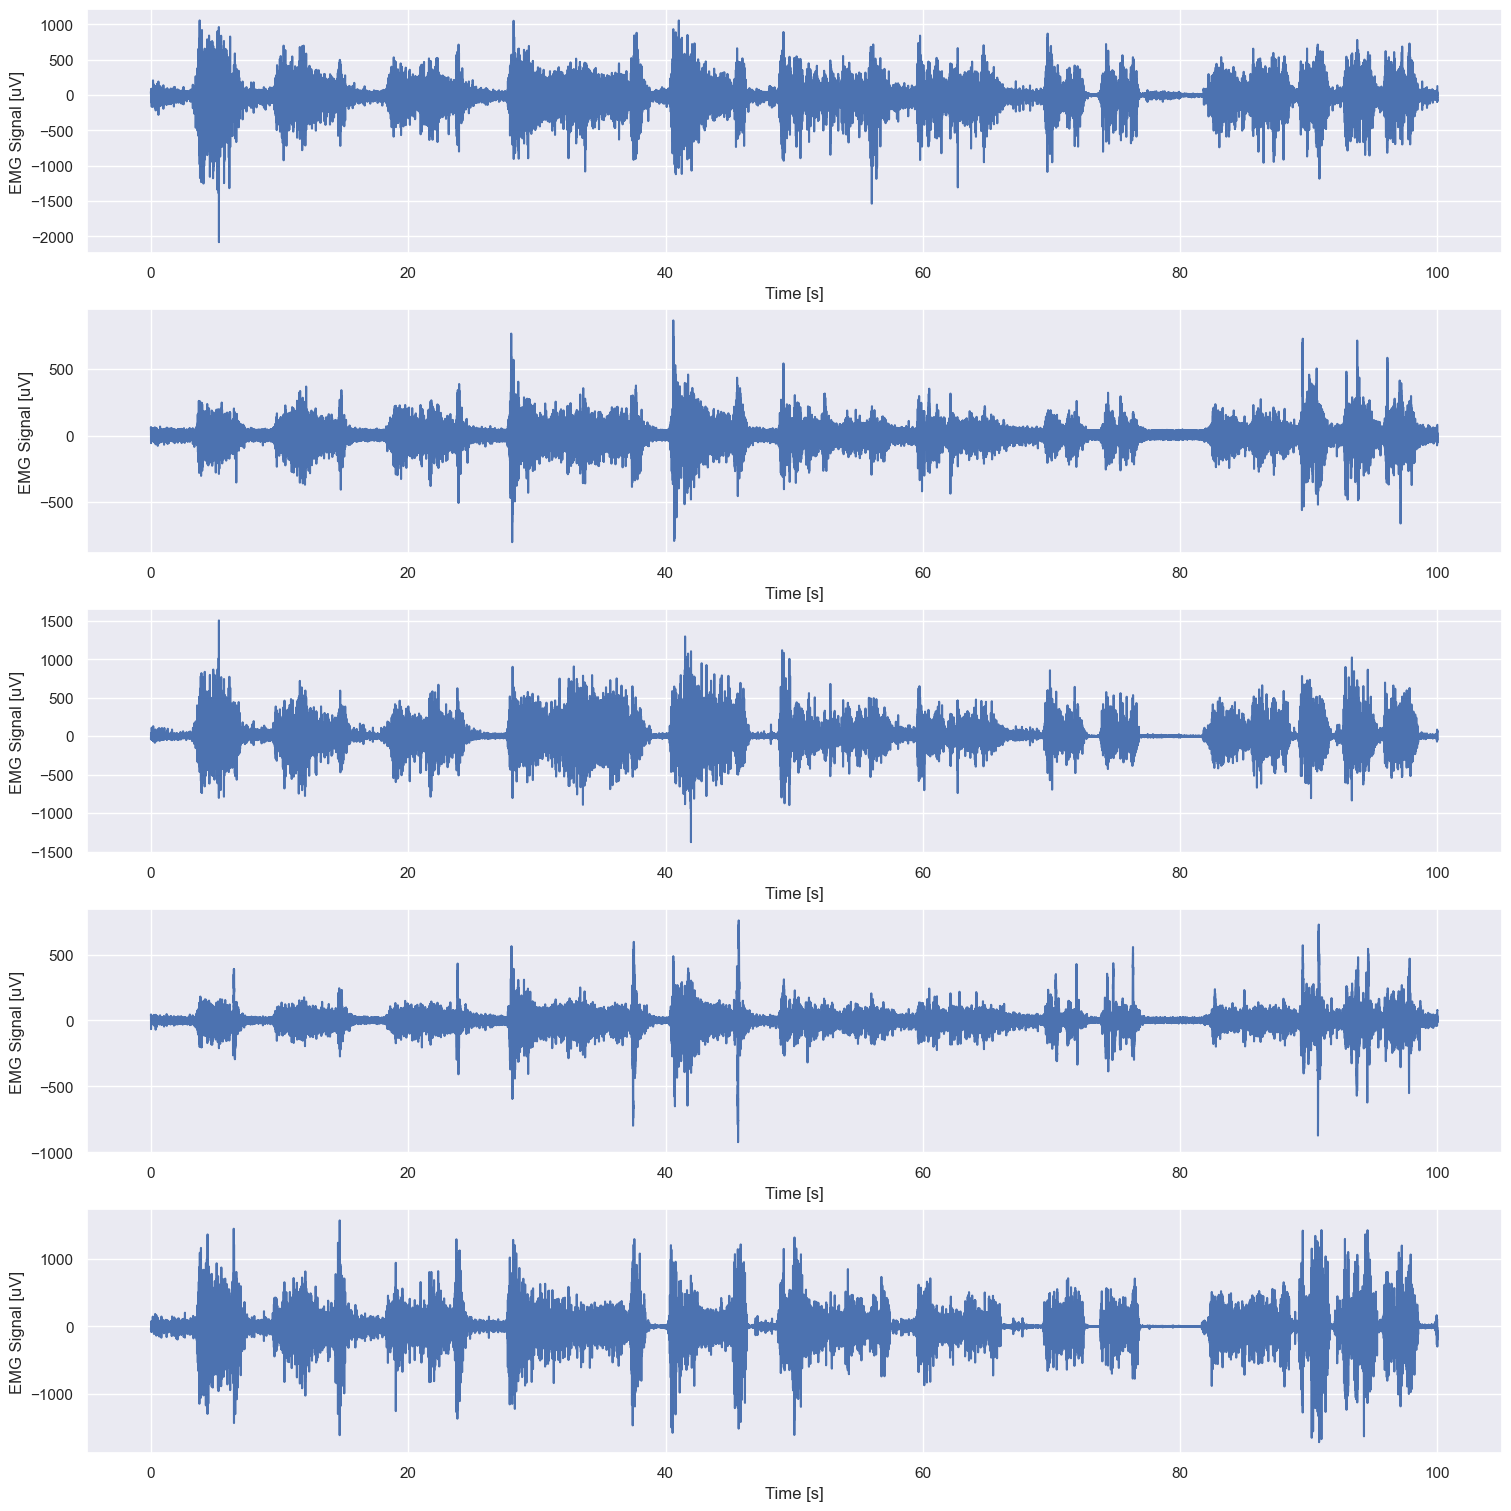

In [3]:
n_channels = emg.shape[1]

#Time vector for plotting : create evenly spaced time bins from 0 to the total duration of the signal in s
time_steps = np.arange(0,emg.shape[0]/fs, 1/fs)

fig, ax = plt.subplots(n_channels, 1, constrained_layout=True, figsize=(15, 15))
for channel_idx in range(n_channels):
    ax[channel_idx].plot(time_steps, emg[:, channel_idx])
    ax[channel_idx].set_xlabel("Time [s]")
    ax[channel_idx].set_ylabel("EMG Signal [uV]")


<div style="background-color:#f2f2f2; padding:10px 15px; border-radius:6px; line-height:1.6;">

The EMG data you just saw is very close to raw data, meaning it likely contains noise from the environment.

##### 1. Bandpass filtering
As a first preprocessing step, we need to apply a **bandpass filter** to isolate the frequencies of interest, a.k.a the frequency where EMG signals live in.

We use a **Butterworth filter** with cutoff frequencies at **5 Hz** and **500 Hz**, according to domain knowledge that most EMG signals concentrate in frequencies lower than 500Hz. 
- The lower bound removes mainly movement artefacts.  
- The upper bound removes high-frequency noise.

##### 2. Powerline noise
Depending on the data acquisition system, the signal might contain noticeable powerline noise:  
- 50 Hz in Europe  
- 60 Hz in the US and Japan

In the case where the powergrid noise is significant, it is necessary to filter it out using a **bandstop filter**. Depending on the strength of the powergrid noise, you might need to filter the **harmonics** of it (the integer multiples of 50Hz +- 2Hz). 
 
For more information look at the documentation : 
- [scipy.signal.butter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html)  
- [scipy.signal.sosfiltfilt](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.sosfiltfilt.html)

</div>

<div style="background-color:#ffdddd; padding:10px; border-left:5px solid #ff0000; border-radius:5px; margin:5px 0;">
<strong>TODO:</strong> Denoise filtering
</div>

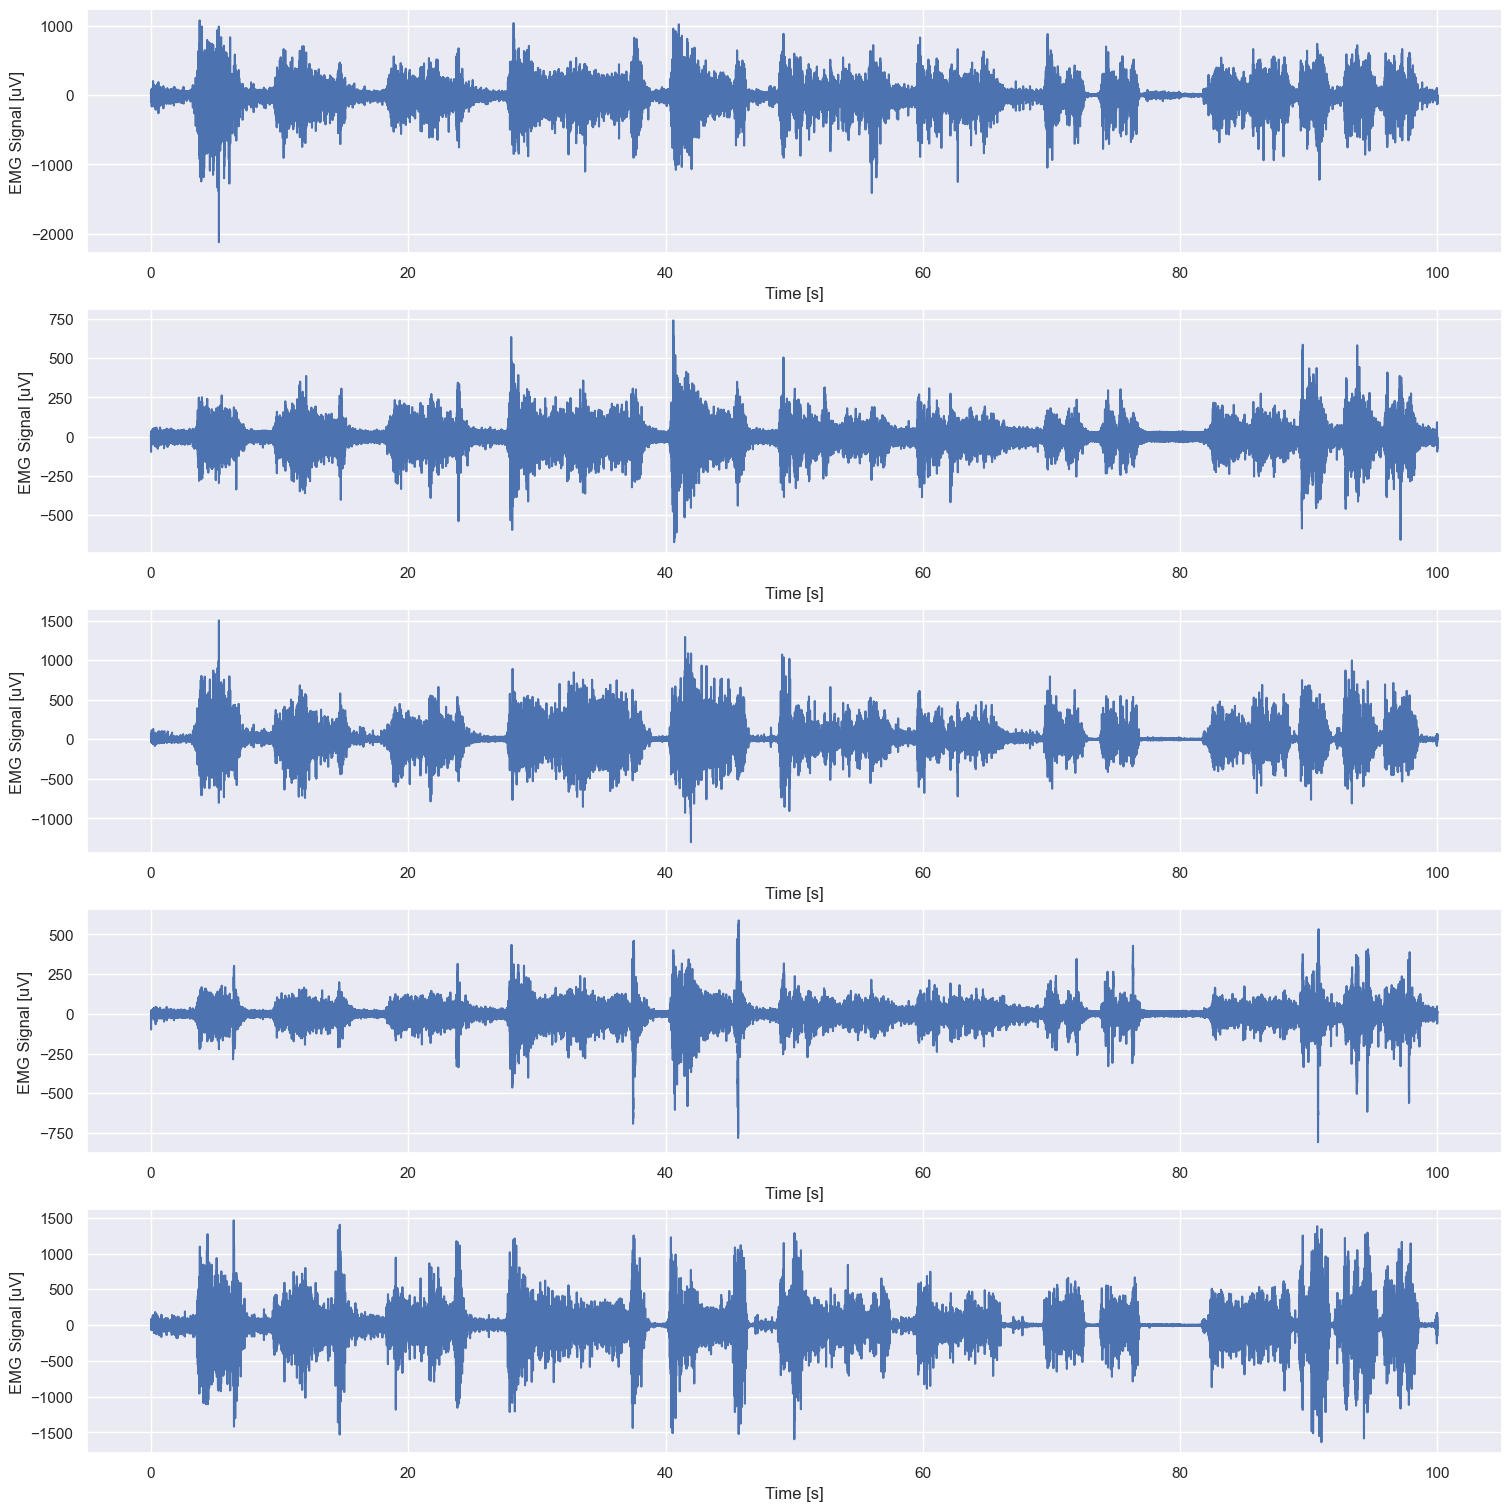

In [4]:
# apply bandpass filter
bandpass_cutoff_frequencies_Hz = (5, 500) 
sos = butter(N=4, Wn=bandpass_cutoff_frequencies_Hz, fs=fs, btype="bandpass", output="sos") 
emg_filtered = sosfiltfilt(sos, emg.T).T 


powergrid_noise_frequencies_Hz = [harmonic_idx*50 for harmonic_idx in range(1,3)] # removing 50Hz noise and its harmonics

for noise_frequency in powergrid_noise_frequencies_Hz:
    sos = butter(N=4, Wn=(noise_frequency - 2, noise_frequency + 2), fs=fs, btype="bandstop", output="sos")
    emg_filtered = sosfiltfilt(sos, emg_filtered.T).T

fig, ax = plt.subplots(n_channels, 1, constrained_layout=True, figsize=(15, 15))
for i in range(n_channels):
    ax[i].plot(time_steps, emg_filtered[:, i])
    ax[i].set_xlabel("Time [s]")
    ax[i].set_ylabel("EMG Signal [uV]")

<div style="background-color:#ffdddd; padding:10px; border-left:5px solid #ff0000; border-radius:5px; margin:5px 0;">
<strong>TODO:</strong> Let's check how the power spectral density changed after filtering. You can use <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html">welch</a>'s method for power spectral density estimation, it reduces the variance of the estimate.
</div>

Text(0.5, 1.0, 'Power Spectral Density plot in Log scale')

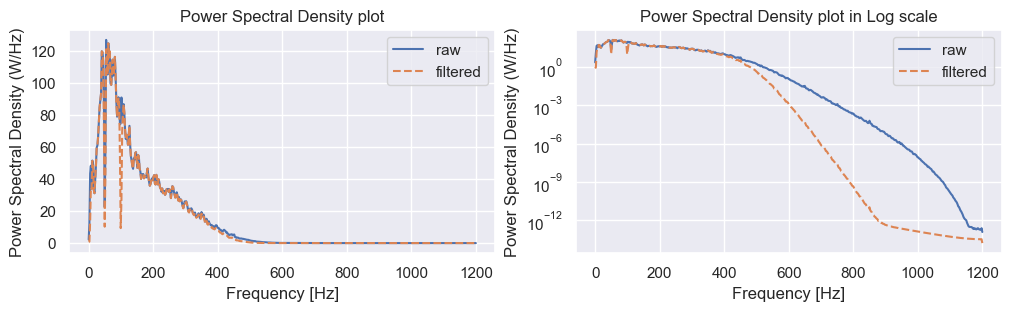

In [5]:
#Use Welch's method for power spectral density estimation, it reduces the variance of the estimate.
freqs_pre, Pxx_pre = welch(emg[:, 0], fs=fs, nperseg=1064)
freqs_post, Pxx_post = welch(emg_filtered[:, 0],fs = fs,  nperseg=1064)

fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3))
ax[0].plot(freqs_pre, Pxx_pre, label="raw")
ax[0].plot(freqs_post, Pxx_post, linestyle="--", label="filtered")
ax[0].legend()
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Power Spectral Density (W/Hz)")
ax[0].set_title("Power Spectral Density plot")

ax[1].semilogy(freqs_pre, Pxx_pre, label="raw")
ax[1].semilogy(freqs_post, Pxx_post, linestyle="--", label="filtered")
ax[1].legend()
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Power Spectral Density (W/Hz)")
ax[1].set_title("Power Spectral Density plot in Log scale")

<div style="background-color:#ffdddd; padding:10px; border-left:5px solid #ff0000; border-radius:5px; margin:5px 0;">
<strong>TODO:</strong> Now we rectify the signal in order to better quantify the muscular activation.
</div>

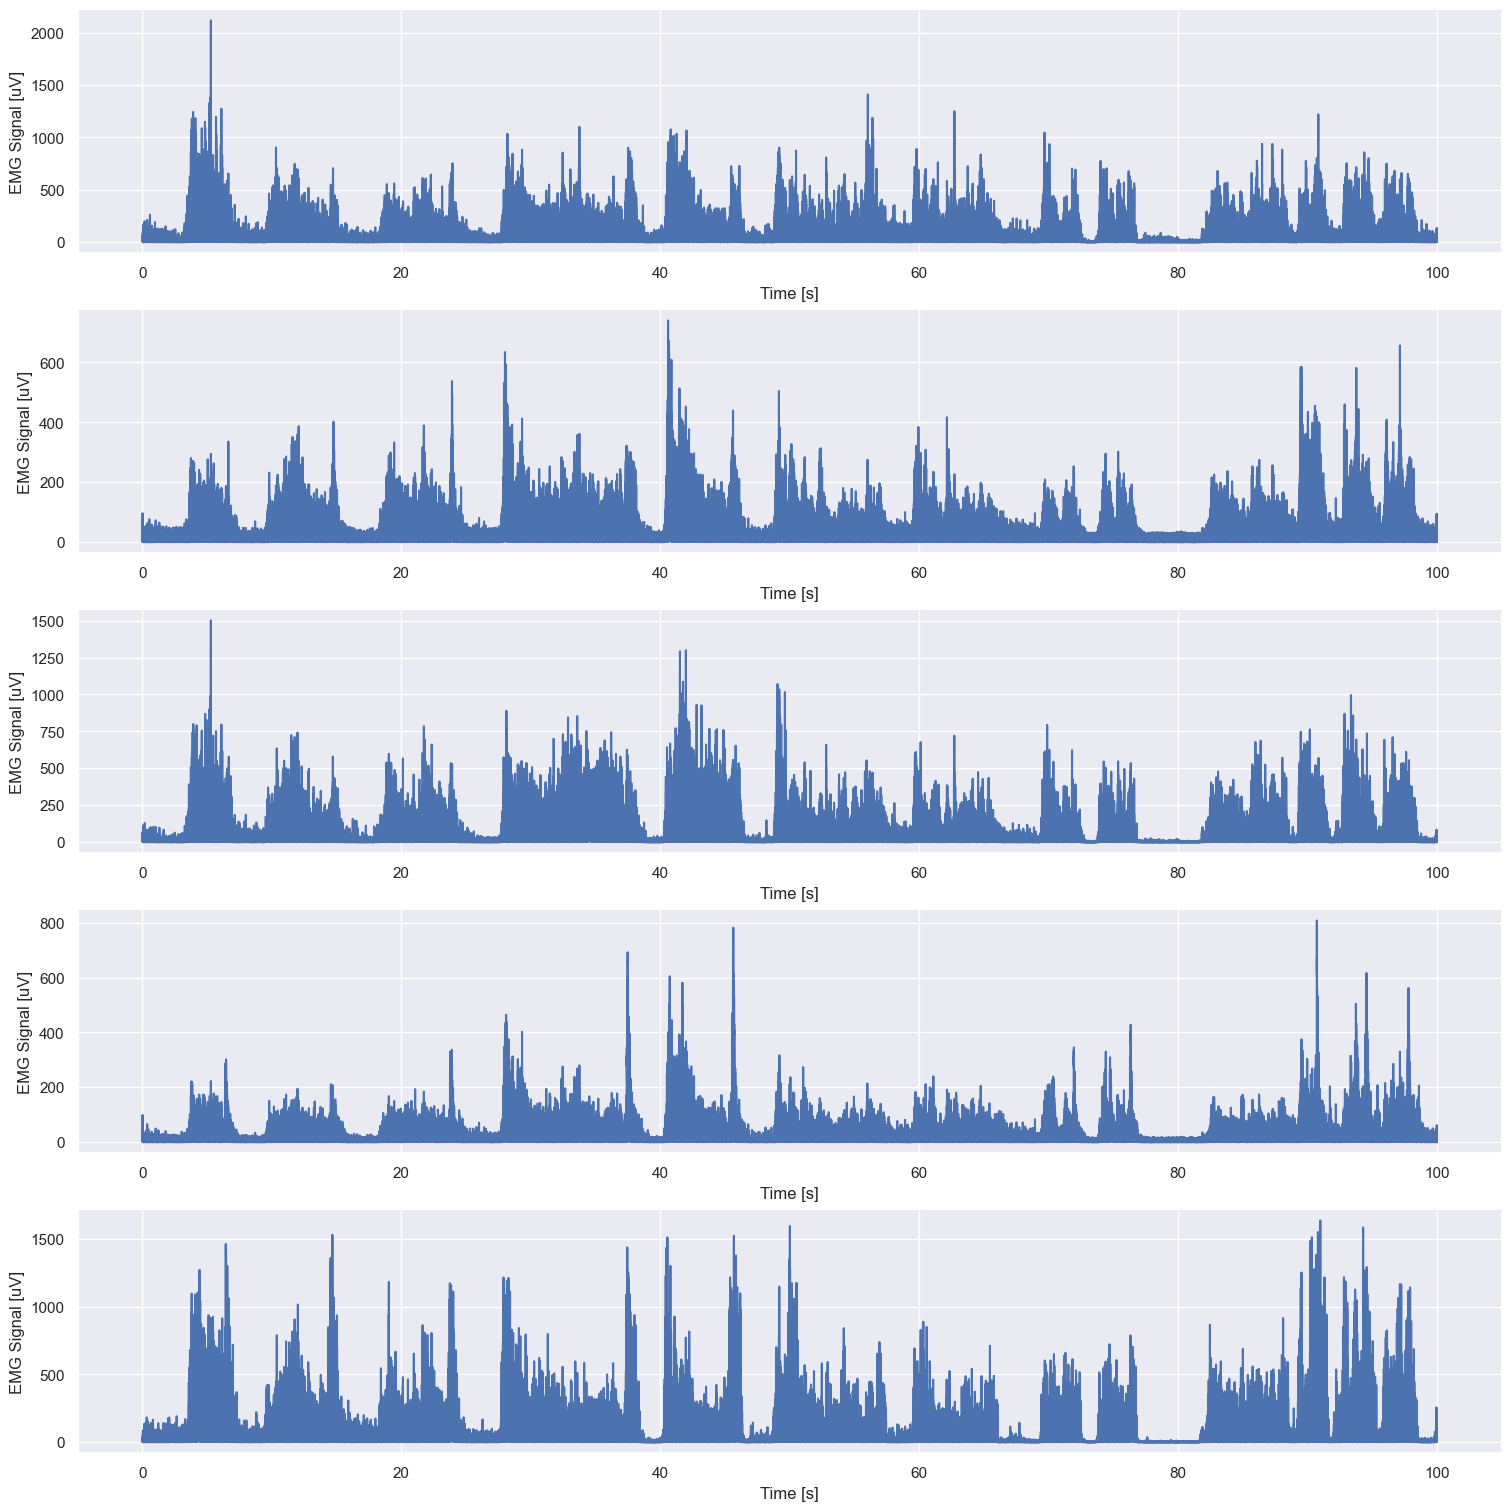

In [6]:
# Rectify signals
emg_rectified = np.abs(emg_filtered) # Rectify the signal

fig, ax = plt.subplots(n_channels, 1, constrained_layout=True, figsize=(15, 15))
for channel_idx in range(n_channels):
    ax[channel_idx].plot(time_steps, emg_rectified[:, channel_idx])
    ax[channel_idx].set_xlabel("Time [s]")
    ax[channel_idx].set_ylabel("EMG Signal [uV]")


<div style="background-color:#ffdddd; padding:10px; border-left:5px solid #ff0000; border-radius:5px; margin:5px 0;">
<strong>TODO:</strong> As a last step, we compute the envelop of the signal by applying a moving average. You can do so by using <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.convolve1d.html">convolve1d</a> 
</div>


Text(0.5, 0.98, 'EMG envelopes')

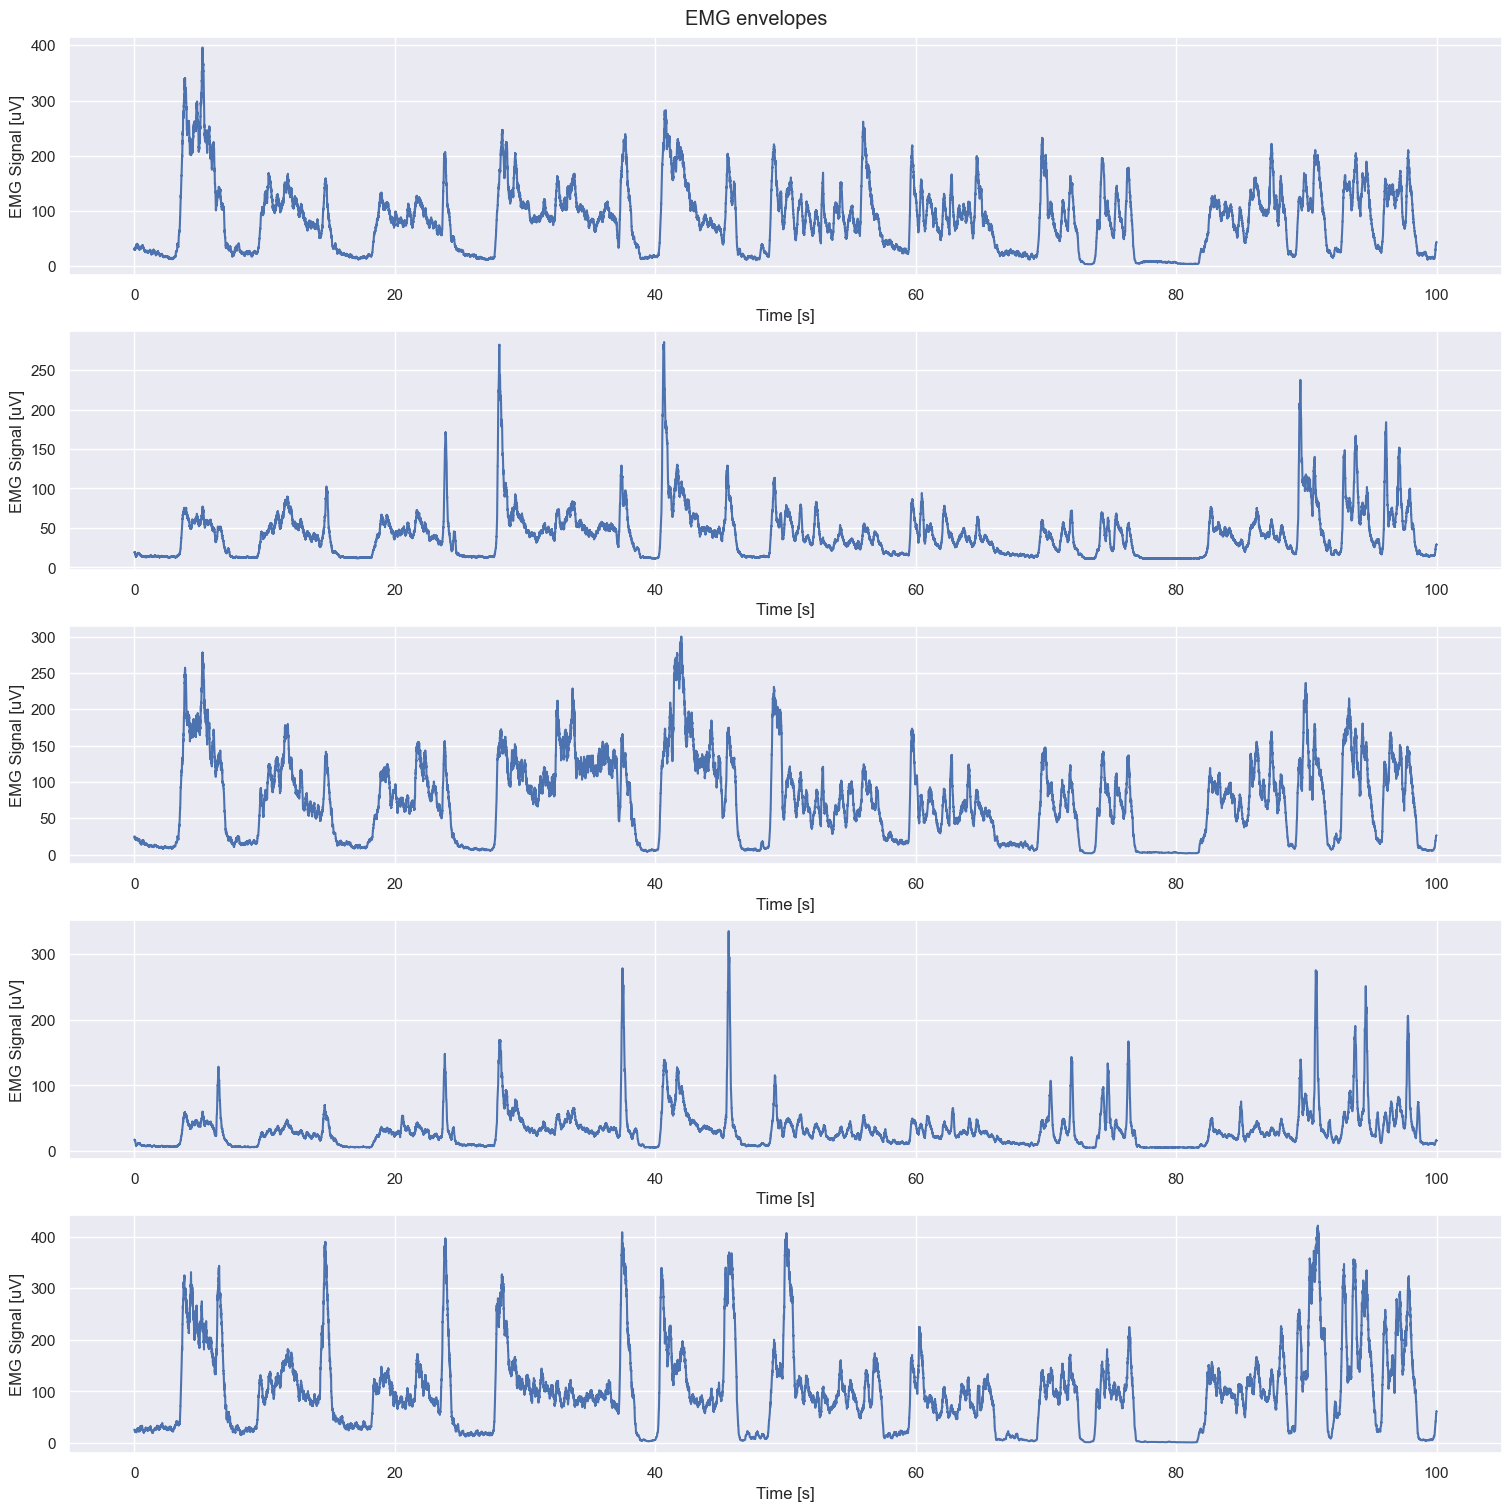

In [7]:
mov_mean_size = 400
mov_mean_weights = np.ones(mov_mean_size) / mov_mean_size
emg_envelopes = convolve1d(emg_rectified, weights=mov_mean_weights, axis=0) # convolve1d the rectified signal with the moving average weights


fig, ax = plt.subplots(n_channels, 1, constrained_layout=True, figsize=(15, 15))
for channel_idx in range(n_channels):
    ax[channel_idx].plot(time_steps, emg_envelopes[:, channel_idx])
    ax[channel_idx].set_xlabel("Time [s]")
    ax[channel_idx].set_ylabel("EMG Signal [uV]")
plt.suptitle("EMG envelopes")